In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import IsolationForest
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet


In [29]:
cybersec = pd.read_excel(r".\Global_Cybersecurity_Threats.xlsx")
cybersec.head()

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169.0,Hacker Group,Unpatched Software,VPN,63.0
1,China,2019,Ransomware,Retail,NaN,295961.0,Hacker Group,Unpatched Software,Firewall,71.0
2,India,2017,Man-in-the-Middle,IT,38.65,605895.0,Hacker Group,Weak Passwords,VPN,20.0
3,UK,2024,Ransomware,Telecommunications,41.44,659320.0,Nation-state,Social Engineering,AI-based Detection,7.0
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682.0,NaN,Social Engineering,VPN,68.0


In [30]:
cybersec.dtypes

Country                                 object
Year                                     int64
Attack Type                             object
Target Industry                         object
Financial Loss (in Million $)          float64
Number of Affected Users               float64
Attack Source                           object
Security Vulnerability Type             object
Defense Mechanism Used                  object
Incident Resolution Time (in Hours)    float64
dtype: object

##### Correct data type

In [31]:
categorical_cols = [
    'Attack Type',
    'Target Industry',
    'Attack Source',
    'Security Vulnerability Type',
    'Defense Mechanism Used'
]
for col in categorical_cols:
    cybersec[col] = cybersec[col].astype('category')

print(cybersec.dtypes)

Country                                  object
Year                                      int64
Attack Type                            category
Target Industry                        category
Financial Loss (in Million $)           float64
Number of Affected Users                float64
Attack Source                          category
Security Vulnerability Type            category
Defense Mechanism Used                 category
Incident Resolution Time (in Hours)     float64
dtype: object


##### Check for NAs

In [32]:
missing = cybersec.isnull().sum()
print(missing)

Country                                  0
Year                                     0
Attack Type                             98
Target Industry                          0
Financial Loss (in Million $)          129
Number of Affected Users               102
Attack Source                           79
Security Vulnerability Type             77
Defense Mechanism Used                   0
Incident Resolution Time (in Hours)     76
dtype: int64


##### Conduct the Little's MCAR test 

In [33]:
from pyampute.exploration.mcar_statistical_tests import MCARTest

In [34]:
#Select columns with missing values to test
subset = cybersec[['Attack Type',
                   'Financial Loss (in Million $)',
                   'Number of Affected Users',
                   'Security Vulnerability Type',
                   'Attack Source',
                   'Incident Resolution Time (in Hours)']]
# Convert categorical variables to numerical codes
subset_encoded = subset.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'category' else col)

In [35]:
mt = MCARTest(method="little")
print(mt.little_mcar_test(subset_encoded))

0.8203963075682454


##### The p-value of the test is 0.82, so we can accept the null hypothesis. Which indicates that the missing pattern of the data is Missing Completely At Random. 

##### Because the missingness is unrelated to the data, we can simply drop all the rows with NA values.

In [36]:
cybersec_cleaned = cybersec.dropna()
cybersec_cleaned.isnull().sum()

Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64

##### Check for outliers

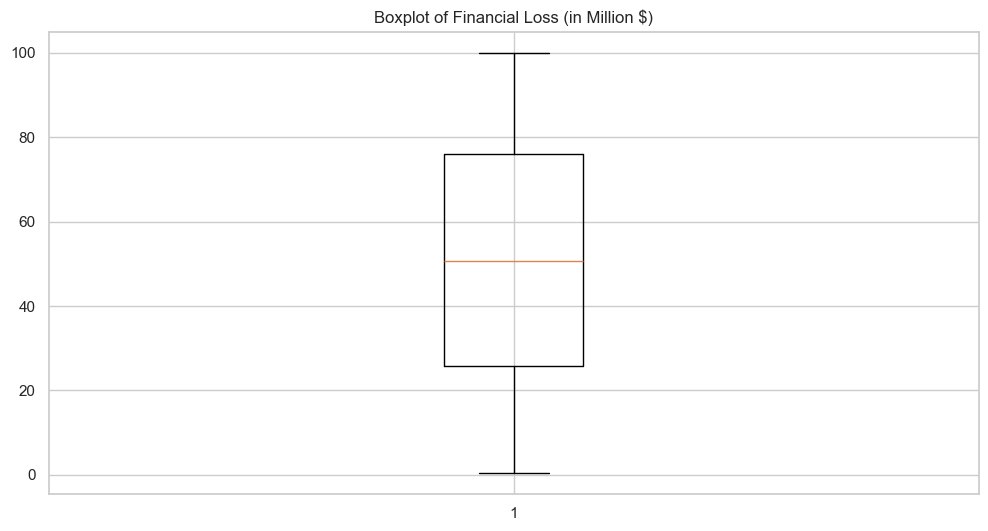

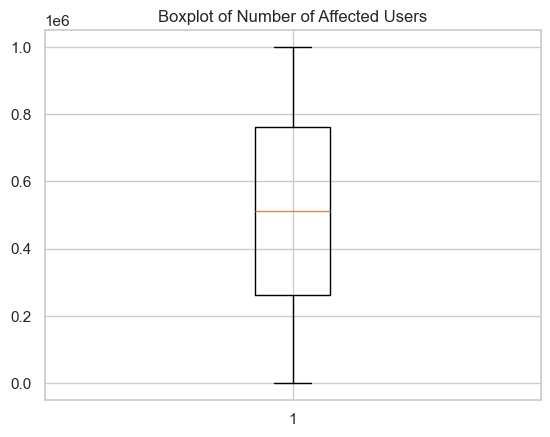

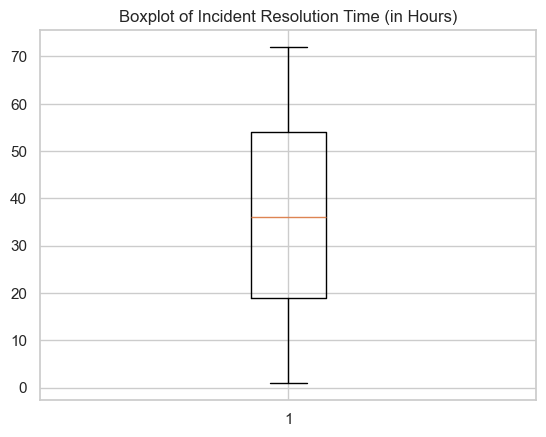

In [37]:
numeric_features = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']
plt.figure(figsize=(12, 6))
for feature in numeric_features:
    plt.boxplot(cybersec_cleaned[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()


# ** 2. TIME SERIES ANALYSIS**

## **2.1. Cybersecurity Threats Over the Years**

In [38]:
incident_trends = cybersec.groupby('Year', observed=False).size().reset_index(name='Incident Count')
x = incident_trends['Year']
y = incident_trends['Incident Count']
coef = np.polyfit(x, y, 1)
trend = np.poly1d(coef)
incident_trends['Trend'] = trend(x)

# Find peak point
max_idx = incident_trends['Incident Count'].idxmax()
max_year = incident_trends.loc[max_idx, 'Year']
max_value = incident_trends.loc[max_idx, 'Incident Count']

fig = px.line(incident_trends, x='Year', y='Incident Count',
              title='Number of Incidents Over Time',
              labels={'Year': 'Year', 'Incident Count': 'Number of Incidents'},
              markers=True)

# Insert Tendency line
fig.add_trace(go.Scatter(
    x=incident_trends['Year'],
    y=incident_trends['Trend'],
    mode='lines',
    name='Trend Line',
    line=dict(color='orange', dash='dash')
))

# Insert Peak
fig.add_trace(go.Scatter(
    x=[max_year],
    y=[max_value],
    mode='markers+text',
    name='Peak',
    marker=dict(color='red', size=10),
    text=[f"Peak: {max_value}"],
    textposition='top center'
))
fig.update_layout(title_x=0.5, xaxis=dict(tickmode='linear'), width=800, height=500)
fig.show()

# 1. Overlook
## 1.1 Top 10 Countries most financially affected by Cyber attack

In [39]:
# Tổng thiệt hại theo quốc gia
country_impact = cybersec_cleaned.groupby('Country')['Financial Loss (in Million $)'].sum().reset_index()

# Lấy top 10 quốc gia thiệt hại cao nhất
top10 = country_impact.sort_values(by='Financial Loss (in Million $)', ascending=False).head(10)

# Vẽ bản đồ choropleth
fig = px.choropleth(top10,
                    locations='Country',
                    locationmode='country names',
                    color='Financial Loss (in Million $)',
                    hover_name='Country',
                    color_continuous_scale='Reds',
                    title='Financial losses for each country affected by Cyber attack')

fig.update_geos(projection_type="natural earth")
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\4144274998.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



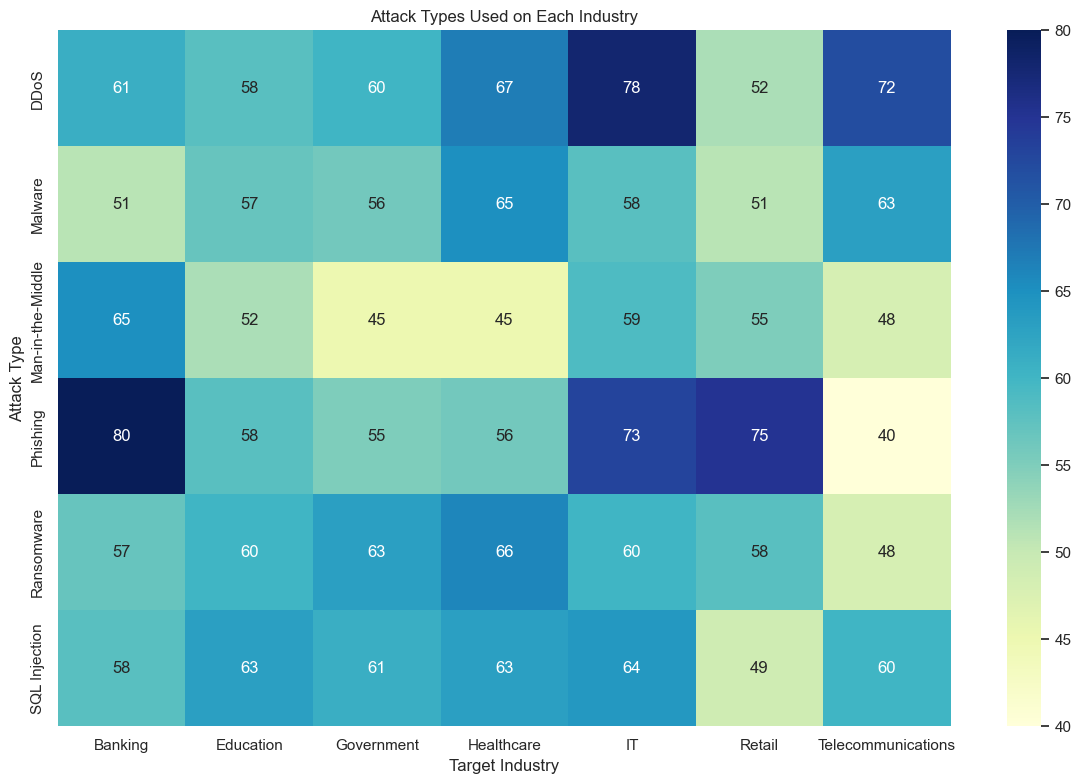

In [40]:
# Group by Attack Type and Target Industry, then count occurrences
industry_attack_counts = cybersec_cleaned.groupby(['Attack Type', 'Target Industry']).size().unstack(fill_value=0)




# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(industry_attack_counts, annot=True, fmt='d', cmap='YlGnBu')




plt.title('Attack Types Used on Each Industry')
plt.xlabel('Target Industry')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\498369034.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\498369034.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\498369034.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\498369034.py:10: FutureWarning:



Pas

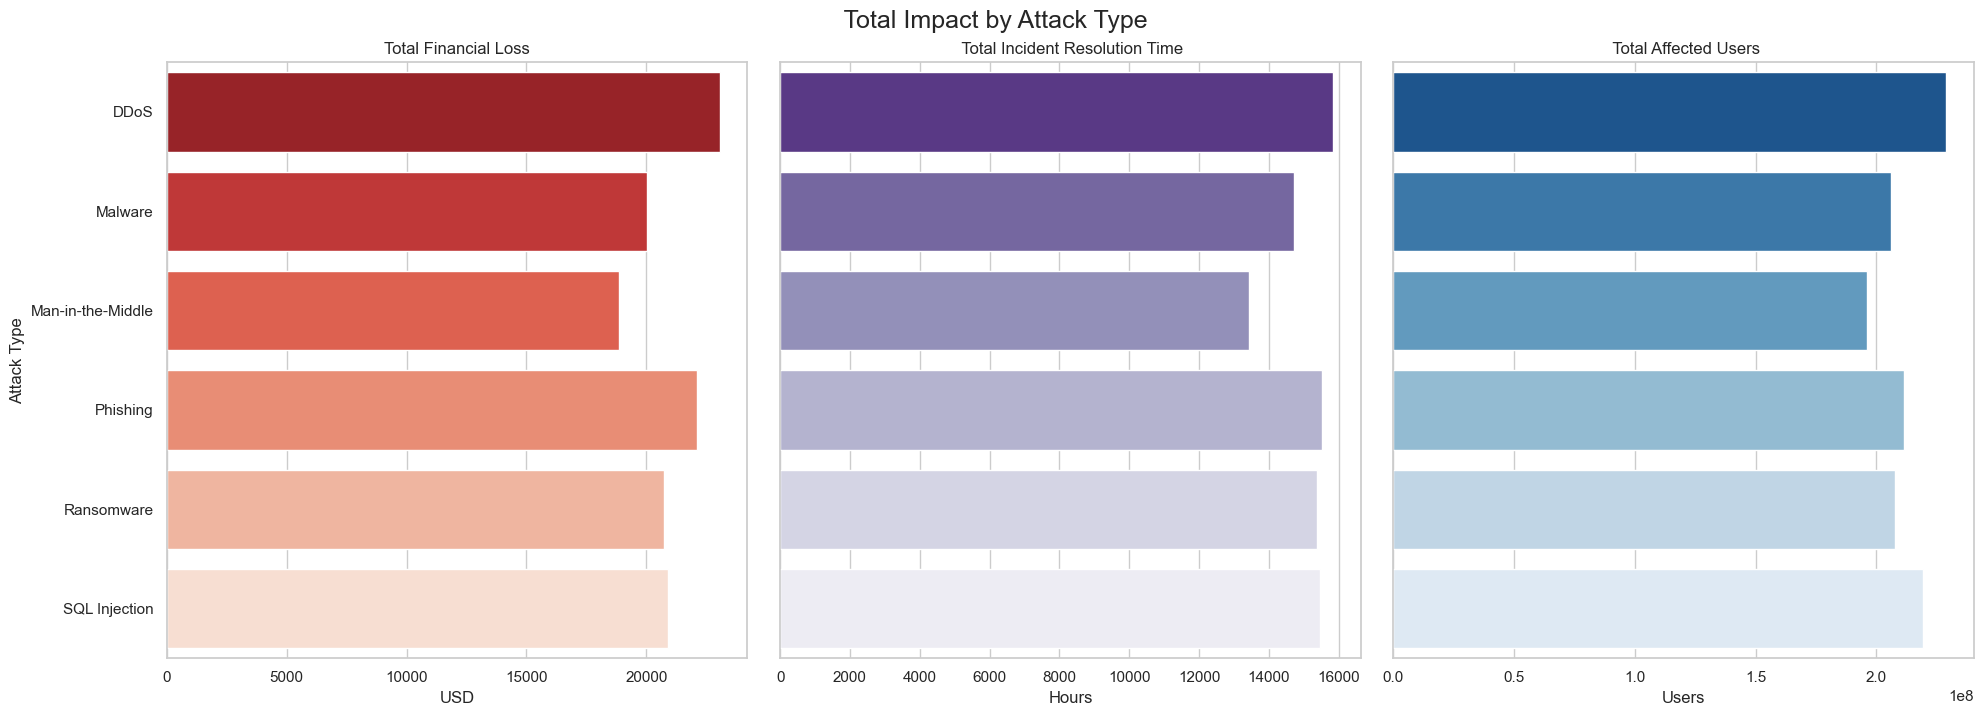

In [41]:
# Prepare data
loss_data = cybersec_cleaned.groupby("Attack Type")["Financial Loss (in Million $)"].sum().sort_values(ascending=False)
time_data = cybersec_cleaned.groupby("Attack Type")["Incident Resolution Time (in Hours)"].sum().sort_values(ascending=False)
users_data = cybersec_cleaned.groupby("Attack Type")["Number of Affected Users"].sum().sort_values(ascending=False)

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)

# Chart 1: Financial Loss
sns.barplot(x=loss_data.values, y=loss_data.index, ax=axes[0], palette="Reds_r")
axes[0].set_title("Total Financial Loss")
axes[0].set_xlabel("USD")
axes[0].set_ylabel("Attack Type")

# Chart 2: Resolution Time
sns.barplot(x=time_data.values, y=time_data.index, ax=axes[1], palette="Purples_r")
axes[1].set_title(" Total Incident Resolution Time")
axes[1].set_xlabel("Hours")
axes[1].set_ylabel("")

# Chart 3: Affected Users
sns.barplot(x=users_data.values, y=users_data.index, ax=axes[2], palette="Blues_r")
axes[2].set_title(" Total Affected Users")
axes[2].set_xlabel("Users")
axes[2].set_ylabel("")

# Layout tweaks
plt.tight_layout()
plt.suptitle(" Total Impact by Attack Type", fontsize=18, y=1.02)
plt.show()

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\4206135983.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



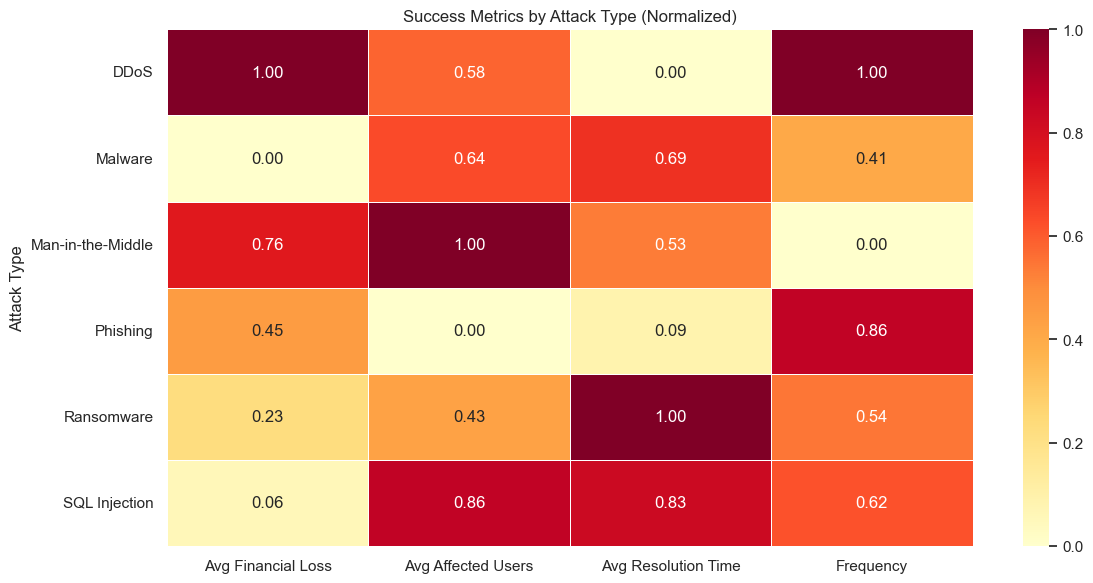

In [42]:

# Group and calculate success metrics
attack_success = cybersec_cleaned.groupby("Attack Type").agg({
    "Financial Loss (in Million $)": "mean",
    "Number of Affected Users": "mean",
    "Incident Resolution Time (in Hours)": "mean",
    "Attack Type": "count"  # Frequency
}).rename(columns={
    "Financial Loss (in Million $)": "Avg Financial Loss",
    "Number of Affected Users": "Avg Affected Users",
    "Incident Resolution Time (in Hours)": "Avg Resolution Time",
    "Attack Type": "Frequency"
})


# Normalize data for better heatmap contrast (optional)
attack_success_normalized = (attack_success - attack_success.min()) / (attack_success.max() - attack_success.min())


# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(attack_success_normalized, annot=True, cmap="YlOrRd", linewidths=0.5, fmt=".2f")
plt.title("Success Metrics by Attack Type (Normalized)")
plt.ylabel("Attack Type")
plt.tight_layout()
plt.show()

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\639424547.py:6: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




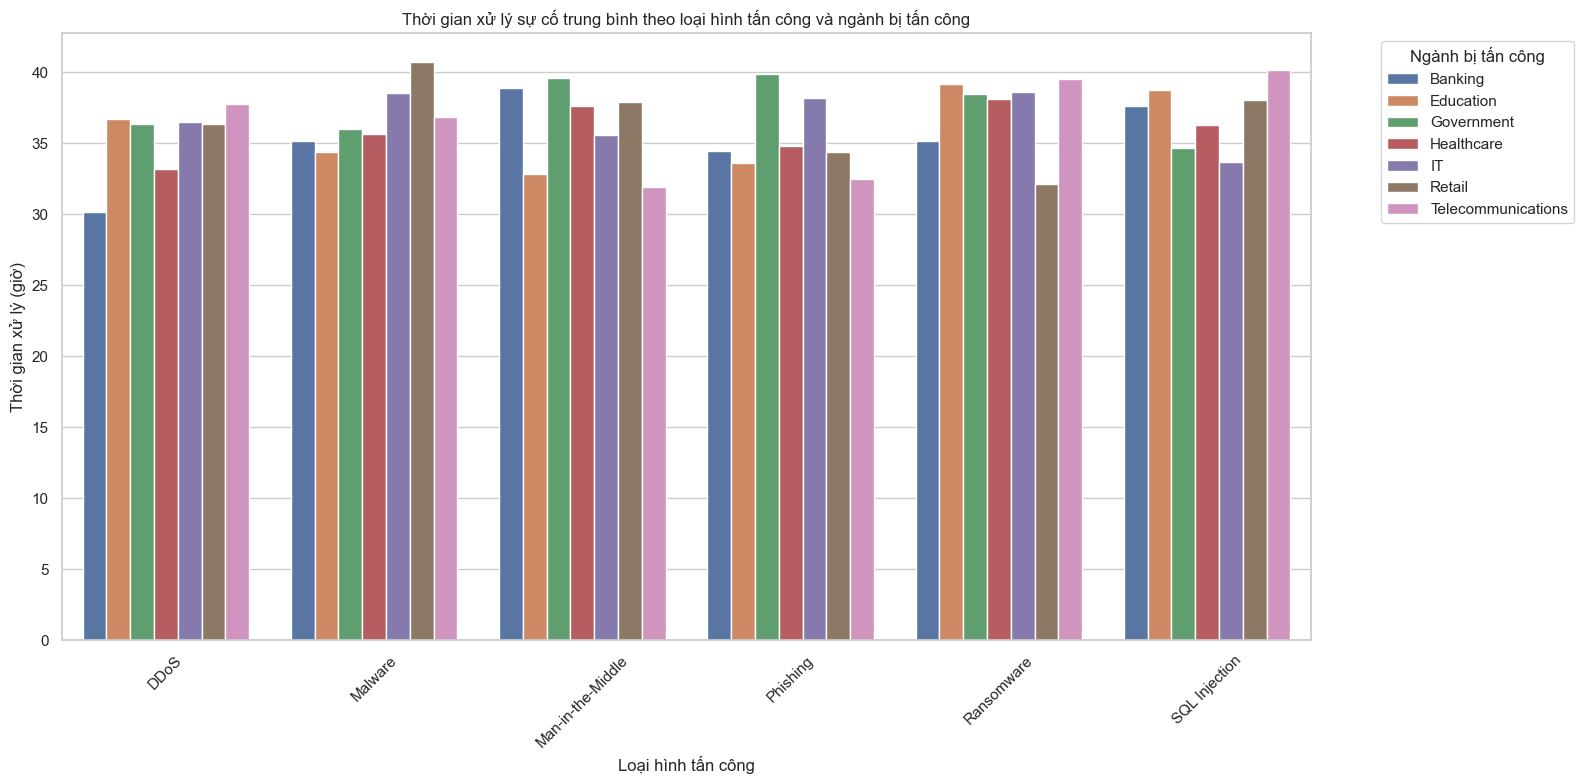

In [43]:
# Thiết lập kích thước và style
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")

# Biểu đồ barplot: Thời gian xử lý trung bình theo Attack Type và Target Industry
sns.barplot(
    data=cybersec_cleaned,
    x="Attack Type",
    y="Incident Resolution Time (in Hours)",
    hue="Target Industry",
    estimator="mean",
    ci=None
)

# Gắn tiêu đề và nhãn trục
plt.title("Thời gian xử lý sự cố trung bình theo loại hình tấn công và ngành bị tấn công")
plt.ylabel("Thời gian xử lý (giờ)")
plt.xlabel("Loại hình tấn công")
plt.xticks(rotation=45)
plt.legend(title="Ngành bị tấn công", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\3282740756.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



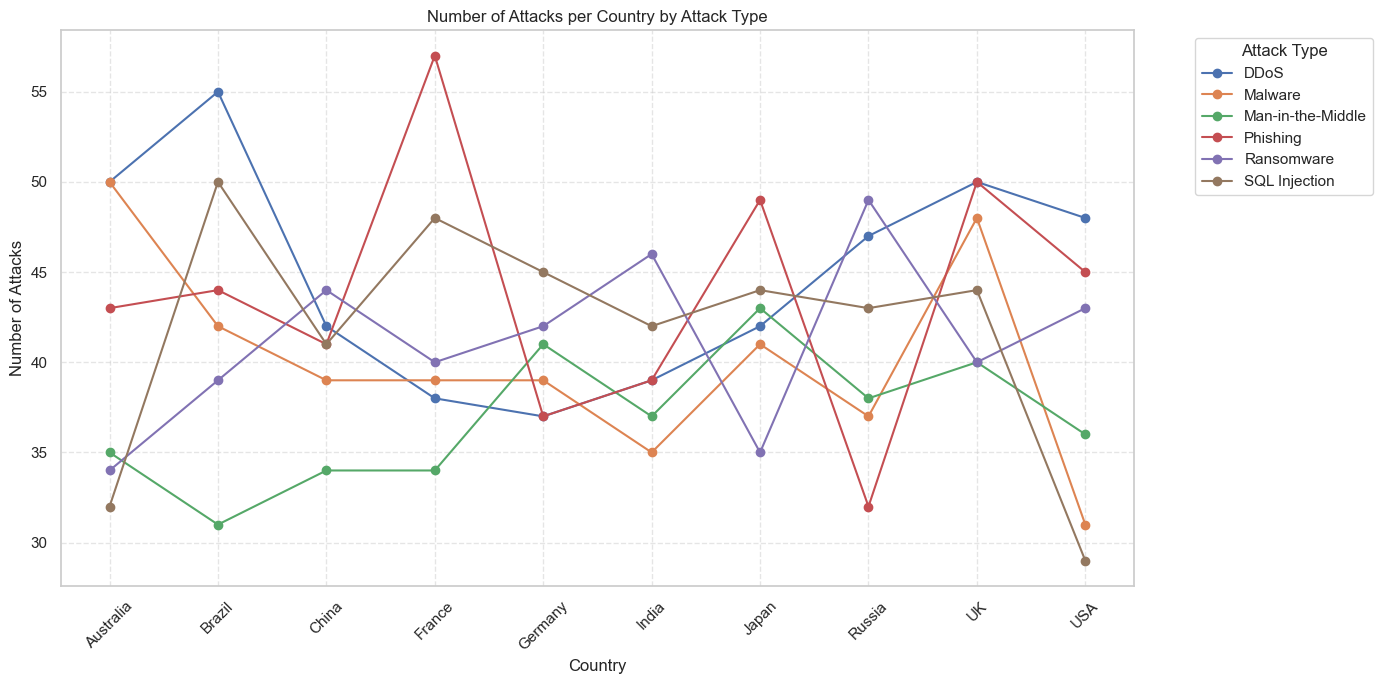

In [44]:
grouped = cybersec_cleaned.groupby(["Country", "Attack Type"]).size().reset_index(name="Attack Count")

# Pivot để tạo định dạng phù hợp cho line chart
pivot_df = grouped.pivot(index="Country", columns="Attack Type", values="Attack Count").fillna(0)

# Vẽ biểu đồ line chart
plt.figure(figsize=(14, 7))
for attack_type in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[attack_type], marker='o', label=attack_type)

plt.title("Number of Attacks per Country by Attack Type")
plt.xlabel("Country")
plt.ylabel("Number of Attacks")
plt.xticks(rotation=45)
plt.legend(title="Attack Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\2915378860.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\2915378860.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




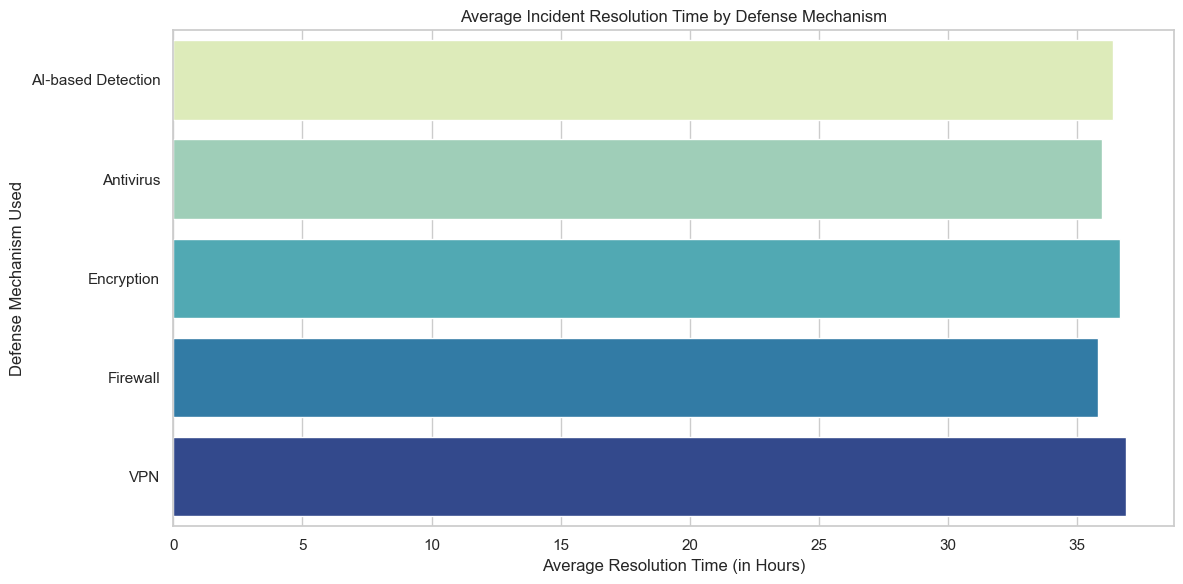

In [45]:
# Lọc dữ liệu đầy đủ
heatmap_df = cybersec_cleaned.dropna(subset=["Defense Mechanism Used", "Incident Resolution Time (in Hours)"])

# Nhóm và tính trung bình thời gian xử lý theo từng cơ chế phòng thủ
grouped = heatmap_df.groupby("Defense Mechanism Used")["Incident Resolution Time (in Hours)"].mean().reset_index()

# Sắp xếp để biểu đồ dễ đọc hơn
grouped = grouped.sort_values(by="Incident Resolution Time (in Hours)", ascending=False)

# Vẽ bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x="Incident Resolution Time (in Hours)", y="Defense Mechanism Used", palette="YlGnBu")

plt.title("Average Incident Resolution Time by Defense Mechanism")
plt.xlabel("Average Resolution Time (in Hours)")
plt.ylabel("Defense Mechanism Used")
plt.tight_layout()
plt.show()




C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\2984821243.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\2984821243.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




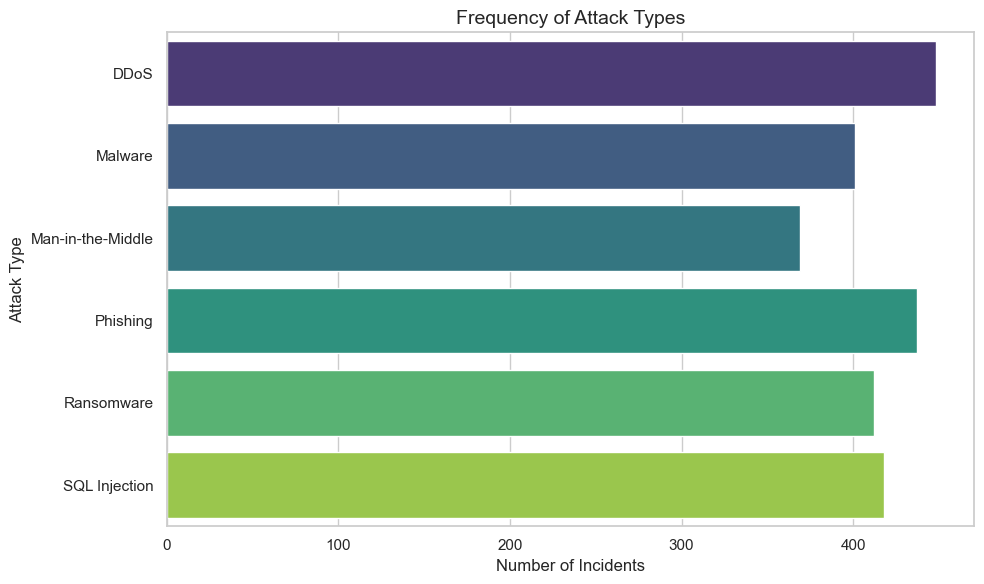

In [46]:
# Nhóm dữ liệu theo Loại Tấn Công để tính tổng số vụ tấn công
attack_type_frequency = cybersec_cleaned.groupby('Attack Type').size().reset_index(name='Number of Incidents')


# Vẽ biểu đồ cột ngang để hiển thị tần suất các loại tấn công
plt.figure(figsize=(10, 6))
sns.barplot(data=attack_type_frequency, x='Number of Incidents', y='Attack Type', palette='viridis')
plt.title('Frequency of Attack Types', fontsize=14)
plt.xlabel('Number of Incidents', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\2538274733.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



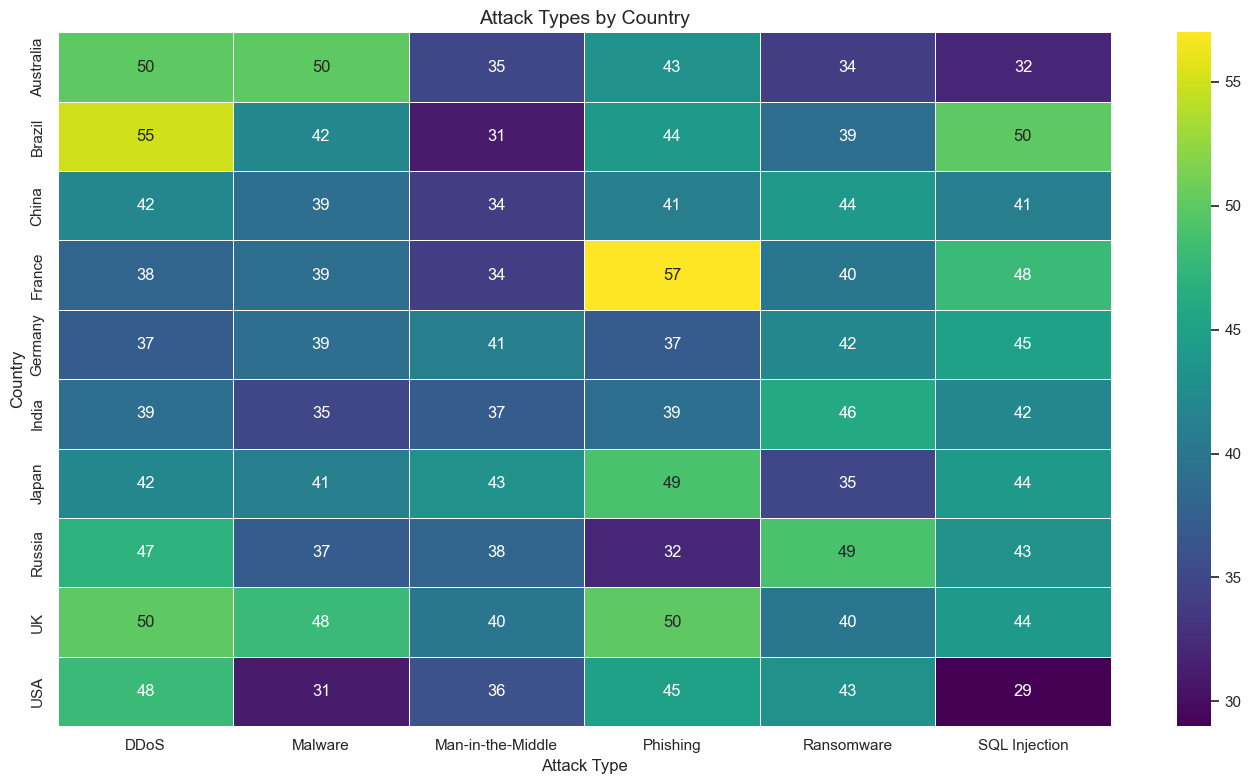

In [47]:
# Nhóm dữ liệu theo Quốc Gia và Loại Tấn Công để tính tổng số vụ tấn công
attack_by_country = cybersec_cleaned.groupby(['Country', 'Attack Type']).size().unstack(fill_value=0)

# Vẽ heatmap để hiển thị số lượng vụ tấn công theo quốc gia và loại tấn công
plt.figure(figsize=(14, 8))
sns.heatmap(attack_by_country, annot=True, fmt='d', cmap='viridis', linewidths=0.5)
plt.title('Attack Types by Country', fontsize=14)
plt.xlabel('Attack Type', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\4136298419.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\4136298419.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




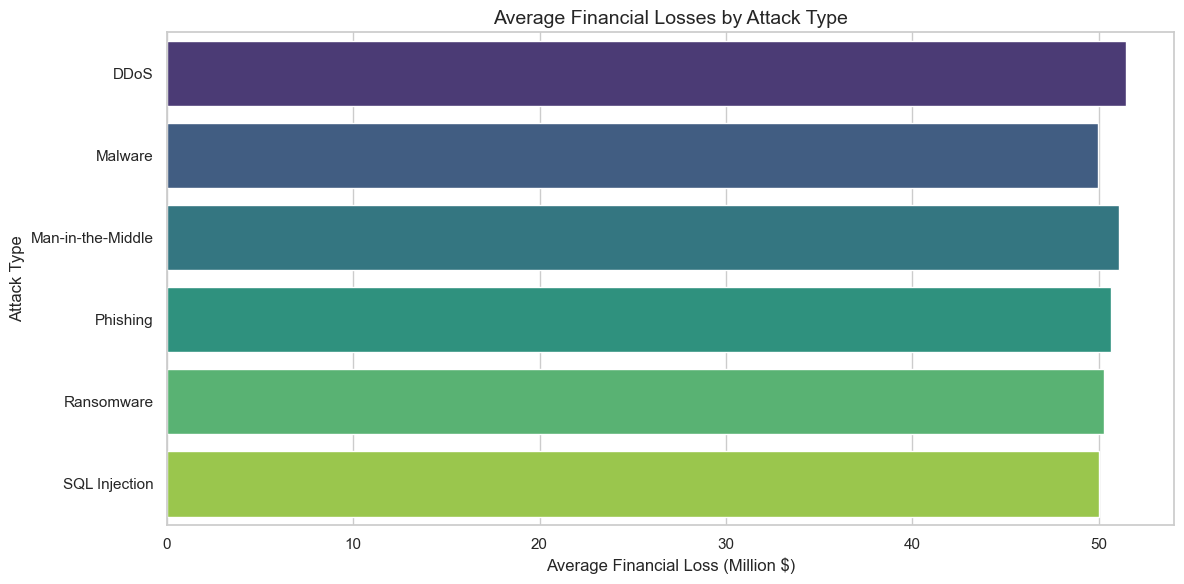

In [48]:
# Tính trung bình thiệt hại tài chính theo loại tấn công
attack_type_losses = cybersec_cleaned.groupby('Attack Type')['Financial Loss (in Million $)'].mean().reset_index()


# Sắp xếp giảm dần theo thiệt hại tài chính trung bình
attack_type_losses = attack_type_losses.sort_values(by='Financial Loss (in Million $)', ascending=False)


# Vẽ biểu đồ cột ngang để hiển thị loại tấn công gây thiệt hại tài chính trung bình cao nhất
plt.figure(figsize=(12, 6))
sns.barplot(data=attack_type_losses, x='Financial Loss (in Million $)', y='Attack Type', palette='viridis')
plt.title('Average Financial Losses by Attack Type', fontsize=14)
plt.xlabel('Average Financial Loss (Million $)', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\3912761169.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




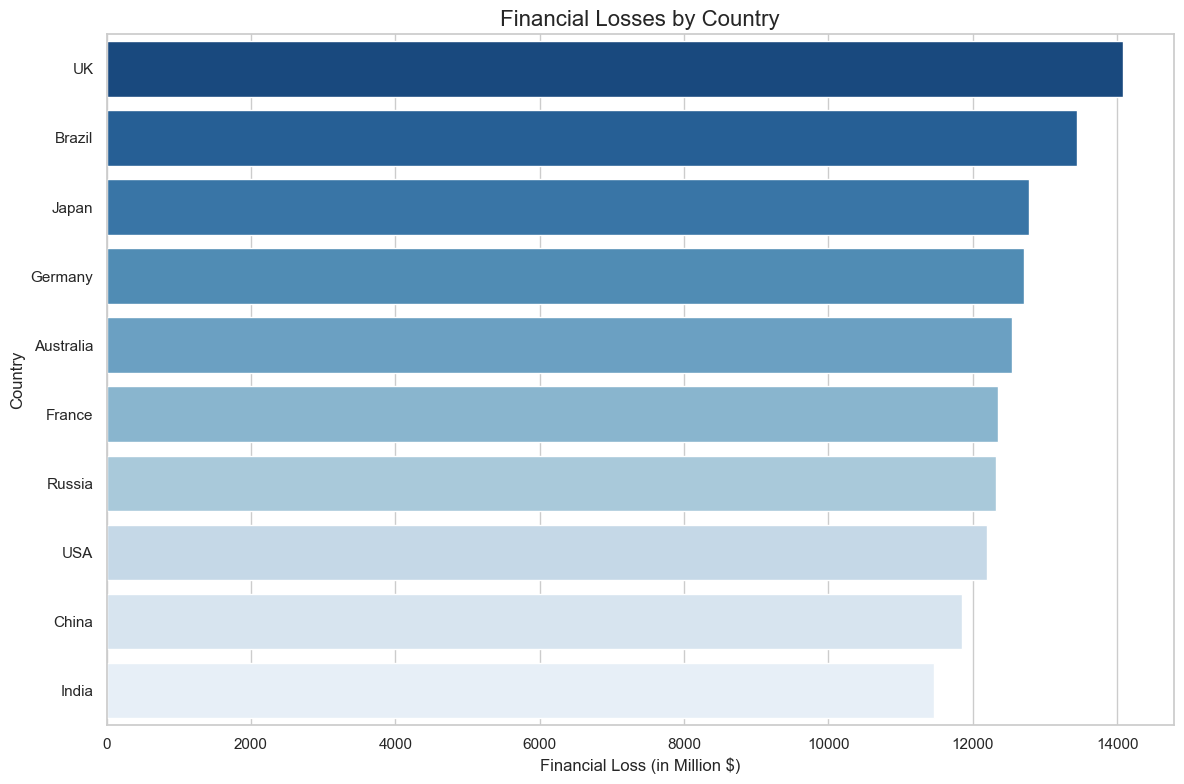

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by country and calculate total financial loss
country_impact = cybersec_cleaned.groupby('Country')['Financial Loss (in Million $)'].sum().reset_index()

# Sort by financial loss in descending order
country_impact = country_impact.sort_values(by='Financial Loss (in Million $)', ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=country_impact, x='Financial Loss (in Million $)', y='Country', palette='Blues_r')
plt.title('Financial Losses by Country', fontsize=16)
plt.xlabel('Financial Loss (in Million $)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\1132539887.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




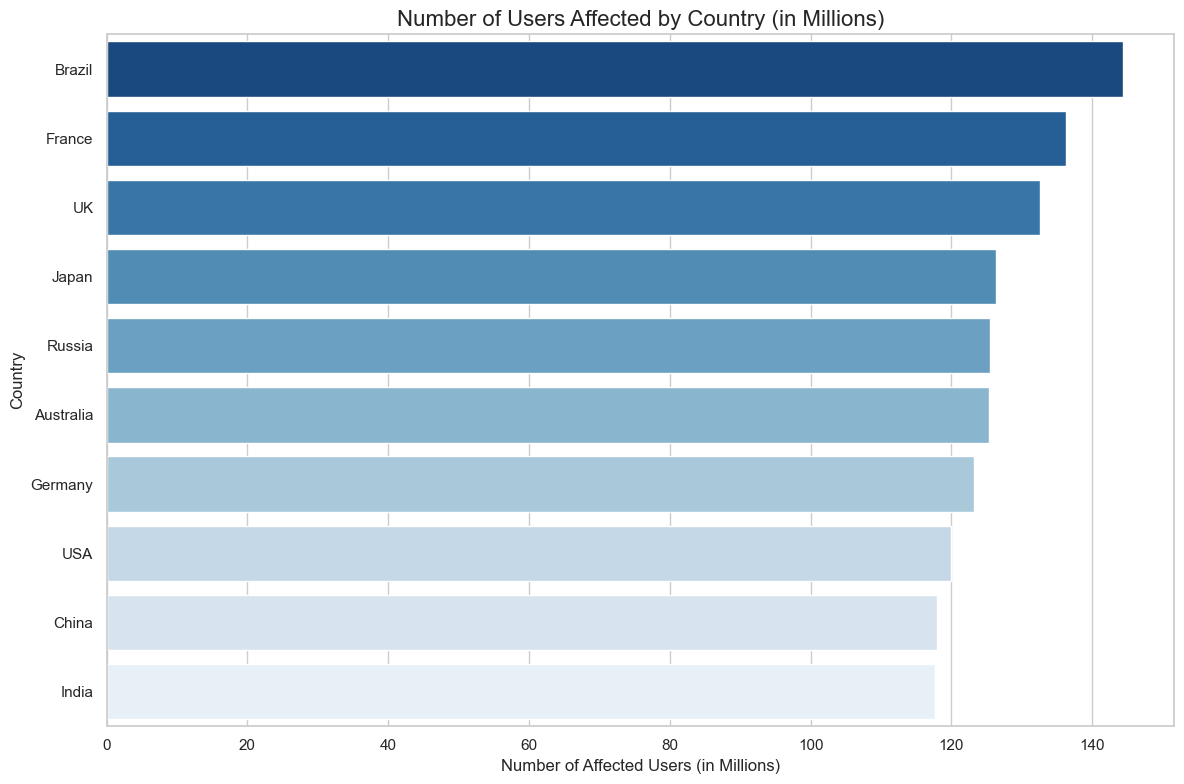

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by country and calculate the total number of affected users
users_affected = cybersec_cleaned.groupby('Country')['Number of Affected Users'].sum().reset_index()

# Sort by the number of affected users in descending order
users_affected = users_affected.sort_values(by='Number of Affected Users', ascending=False)

# Convert the number of affected users to millions
users_affected['Number of Affected Users (in Millions)'] = users_affected['Number of Affected Users'] / 1_000_000

# Plot the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=users_affected, x='Number of Affected Users (in Millions)', y='Country', palette='Blues_r')
plt.title('Number of Users Affected by Country (in Millions)', fontsize=16)
plt.xlabel('Number of Affected Users (in Millions)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\1626942000.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




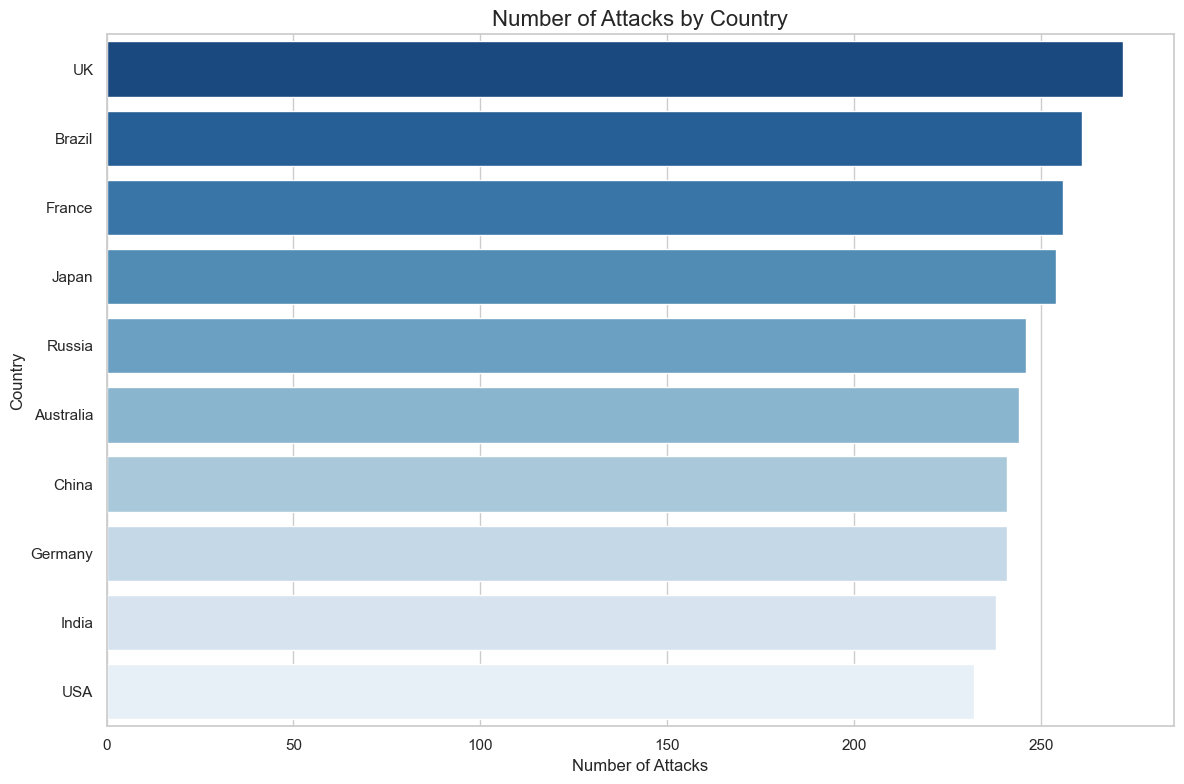

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by country and calculate the total number of attacks
attacks_by_country = cybersec_cleaned.groupby('Country').size().reset_index(name='Number of Attacks')

# Sort by the number of attacks in descending order
attacks_by_country = attacks_by_country.sort_values(by='Number of Attacks', ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=attacks_by_country, x='Number of Attacks', y='Country', palette='Blues_r')
plt.title('Number of Attacks by Country', fontsize=16)
plt.xlabel('Number of Attacks', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\443455876.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\443455876.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




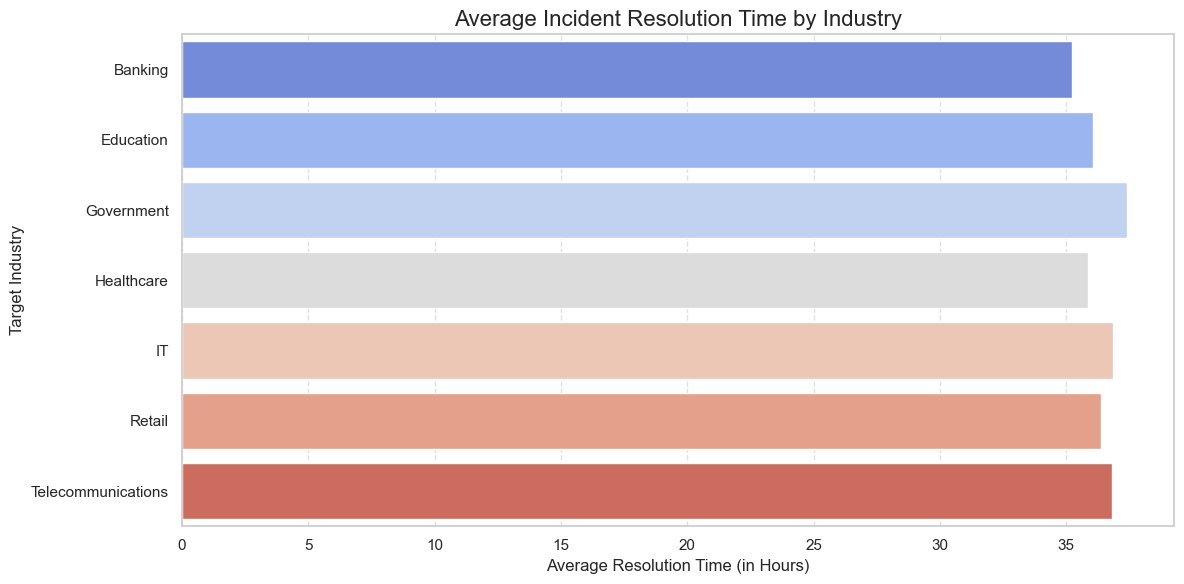

In [52]:
# Tính thời gian xử lý trung bình theo ngành
avg_time_by_industry = (
    cybersec_cleaned.groupby("Target Industry")["Incident Resolution Time (in Hours)"]
    .mean()
    .sort_values()
    .reset_index()
)

# Vẽ bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    data=avg_time_by_industry,
    x="Incident Resolution Time (in Hours)",
    y="Target Industry",
    palette="coolwarm"
)

plt.title("Average Incident Resolution Time by Industry", fontsize=16)
plt.xlabel("Average Resolution Time (in Hours)", fontsize=12)
plt.ylabel("Target Industry", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\2913503626.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




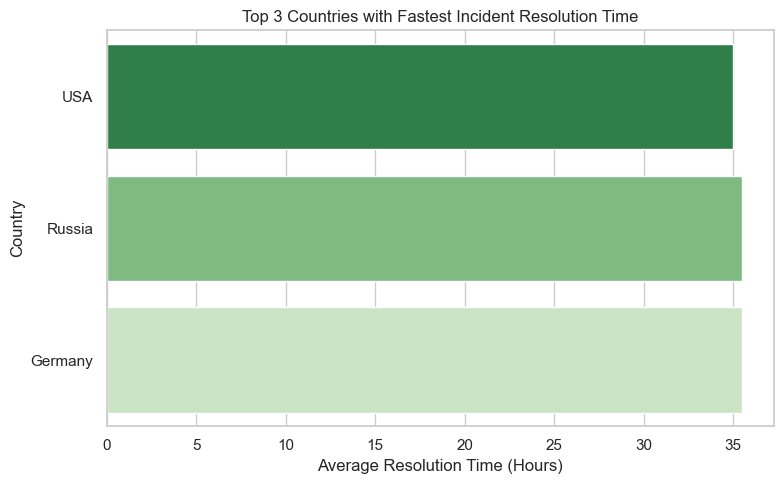

In [53]:
# Tính tổng hoặc trung bình thời gian xử lý theo quốc gia
avg_time_by_country = cybersec_cleaned.groupby("Country")["Incident Resolution Time (in Hours)"].mean().sort_values()

# Lấy 3 quốc gia nhanh nhất
fastest_countries = avg_time_by_country.head(3)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
sns.barplot(x=fastest_countries.values, y=fastest_countries.index, palette="Greens_r")
plt.title("Top 3 Countries with Fastest Incident Resolution Time")
plt.xlabel("Average Resolution Time (Hours)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# **5. 📡FORECASTING INCIDENTS IN 2025 USING ARIMA MODEL**📡

## **5.1. 💸Predict Total Financial Loss in 2025💸**

- Line Graph to show Total Financial Loss over the years:

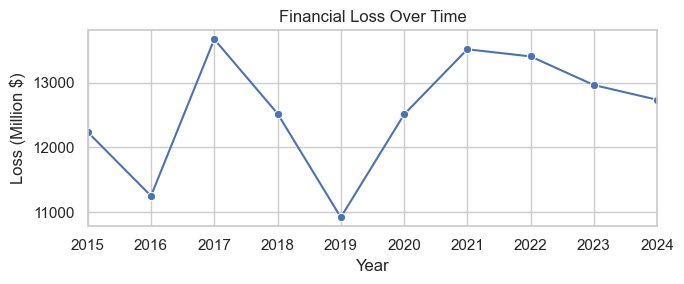

In [54]:
ts_data = cybersec_cleaned.groupby('Year')['Financial Loss (in Million $)'].sum().reset_index()
ts_data.columns = ['timestamp', 't']
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3))
sns.lineplot(x=ts_data['timestamp'], y=ts_data['t'], marker='o', ax=ax)
ax.set_xlim([ts_data['timestamp'].iloc[0], ts_data['timestamp'].iloc[-1]])
ax.set_title('Financial Loss Over Time')
ax.set_ylabel('Loss (Million $)')
ax.set_xlabel('Year')
plt.tight_layout()
plt.show()


### **5.1.1. Check stationarity with ADF test**

In [55]:
result = adfuller(cybersec_cleaned.groupby('Year')['Financial Loss (in Million $)'].sum())
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -1.3459018750859209
p-value: 0.6079194782719871


- The series is **not stationary** because p-value > 0.05. We will take the first difference (d = 1) and then check the stationarity again.

In [56]:
# Lấy sai phân bậc 1\n",
diff_1 = cybersec_cleaned.groupby('Year')['Financial Loss (in Million $)'].sum().diff().dropna()
# Kiểm tra lại tính dừng sau khi lấy sai phân
result_diff = adfuller(diff_1)
print("ADF Statistic (difference):", result_diff[0])
print("p-value (difference):", result_diff[1])

ADF Statistic (difference): -4.509555929886344
p-value (difference): 0.00018896798334489456


👉 As can be seen, p-value is very small, the series has stopped after taking the first difference ⇒ d = 1

### **5.1.2. Draw ACF and PACF to choose order=(p, d, q) for ARIMA model** 

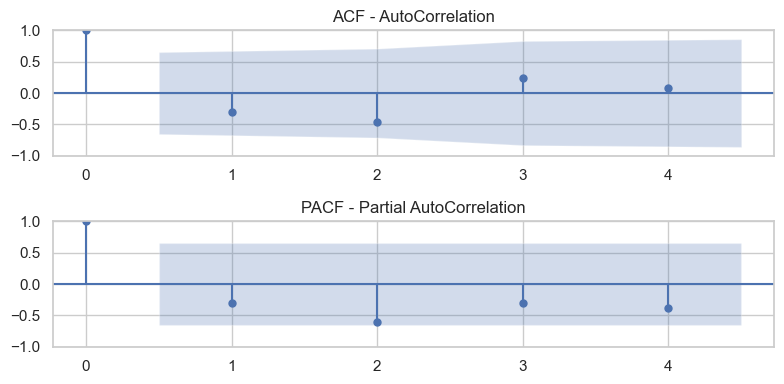

In [57]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
plot_acf(diff_1, ax=ax[0], lags=4)
plot_pacf(diff_1, ax=ax[1], lags=4)
ax[0].set_title("ACF - AutoCorrelation")
ax[1].set_title("PACF - Partial AutoCorrelation")
plt.tight_layout()
plt.show()

- ACF: Cuts off after lag 1 
- PACF: Also decreased sharply after lag 1
- 👉(p,d,q) = (1,1,1)

### **5.1.3. Fit Arima Model**

In [58]:
model = ARIMA(cybersec_cleaned.groupby('Year')['Financial Loss (in Million $)'].sum(), order=(1, 1, 1))
model_fit_finance = model.fit()
print(model_fit_finance.summary())

                                     SARIMAX Results                                     
Dep. Variable:     Financial Loss (in Million $)   No. Observations:                   10
Model:                            ARIMA(1, 1, 1)   Log Likelihood                 -76.209
Date:                           Wed, 16 Apr 2025   AIC                            158.419
Time:                                   22:17:42   BIC                            159.010
Sample:                                        0   HQIC                           157.142
                                            - 10                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5239      0.514     -1.020      0.308      -1.531       0.483
ma.L1          0.3592      0.715      0.502

c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.



In [59]:
forecast_finance_5years = model_fit_finance.forecast(steps=5)
print(forecast_finance_5years)

10    12753.137467
11    12744.583571
12    12749.064924
13    12746.717160
14    12747.947144
Name: predicted_mean, dtype: float64


c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



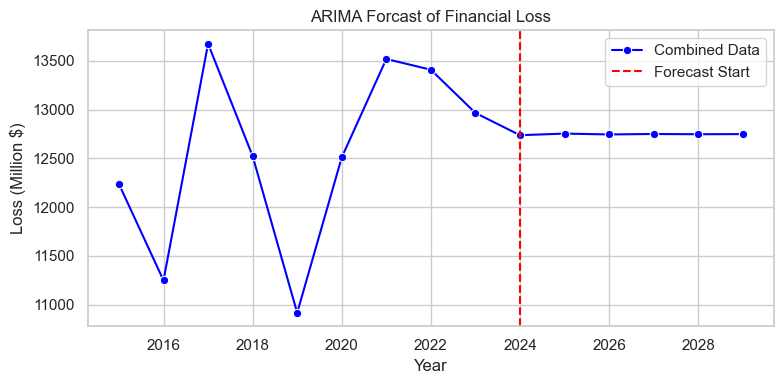

In [61]:
df_real = cybersec_cleaned.groupby('Year')['Financial Loss (in Million $)'].sum().reset_index()
df_real.columns = ['timestamp', 't']
last_year = df_real['timestamp'].max()
forecast_years = pd.Series(range(last_year + 1, last_year + 1 + len(forecast_finance_5years)))
df_forecast = pd.DataFrame({
    'timestamp': forecast_years,
    't': forecast_finance_5years.values
    })
# Ghép dữ liệu gốc và dữ liệu dự báo
df_combined = pd.concat([df_real, df_forecast], ignore_index=True)
# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_combined, x='timestamp', y='t', marker='o', label='Combined Data', color='blue')
plt.axvline(x=df_real['timestamp'].max(), color='red', linestyle='--', label='Forecast Start')
plt.title('ARIMA Forcast of Financial Loss')
plt.xlabel('Year')
plt.ylabel('Loss (Million $)')
plt.legend()
plt.tight_layout()
plt.show()


- **Interpretation:** The forecasted values (2024-2028) show minimal fluctuation around $12.75 million, indicating the model predicts a stable financial loss trend with no significant upward or downward movement. 

## **5.2. 🌐Predict Total Number of Cyber Security Incidents🌐**

### **5.2.1. Fit Arima Model**

In [71]:
df_incidents = cybersec_cleaned.groupby('Year').size().reset_index(name='Incident Count')
time_series = df_incidents.set_index('Year')

In [72]:
# Fit ARIMA model with (p, d, q) = (1, 1, 1)
model_incidents = ARIMA(time_series, order=(1, 1, 1))
model_fit_incidents = model_incidents.fit()
print(model_fit_incidents.summary())

c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible sta

                               SARIMAX Results                                
Dep. Variable:         Incident Count   No. Observations:                   10
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -39.069
Date:                Wed, 16 Apr 2025   AIC                             84.138
Time:                        22:36:06   BIC                             84.730
Sample:                             0   HQIC                            82.861
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0560      0.846      0.066      0.947      -1.601       1.713
ma.L1         -0.9989    194.517     -0.005      0.996    -382.244     380.247
sigma2       270.3750   5.25e+04      0.005      0.9

In [74]:
# Forecast incidents for the next 5 years
forecast_incidents = model_fit_incidents.forecast(steps=5)
forecast_years = pd.Series(range(time_series.index[-1] + 1, time_series.index[-1] + 6))
df_forecast = pd.DataFrame({'Year': forecast_years, 'Incident Count': forecast_incidents.values})
print(df_forecast)

   Year  Incident Count
0  2025      248.259421
1  2026      248.385926
2  2027      248.393009
3  2028      248.393406
4  2029      248.393428


c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [ ]:
# Calculate percentage increase for 2025 compared to 2024
incidents_2024 = time_series.iloc[-1, 0] 
incidents_2025 = df_forecast.loc[df_forecast['Year'] == 2025, 'Incident Count'].values[0]
growth_percentage = ((incidents_2025 - incidents_2024) / incidents_2024) * 100
print(f"Forecasted incidents for 2025: {incidents_2025}")
print(f"Percentage growth in incidents from 2024 to 2025: {growth_percentage:.2f}%")


Forecasted incidents for 2025: 248.25942131911626
Percentage growth in incidents from 2024 to 2025: 0.92%


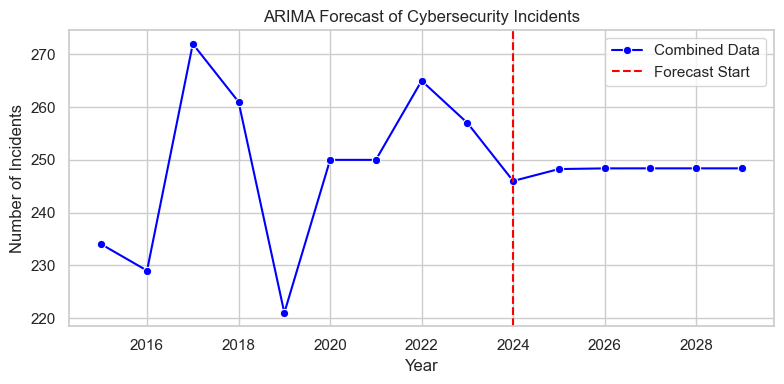

In [76]:
# Combine original and forecasted data
df_combined = pd.concat([df_incidents, df_forecast], ignore_index=True)

# Plot the combined data
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_combined, x='Year', y='Incident Count', marker='o', label='Combined Data', color='blue')
plt.axvline(x=df_incidents['Year'].max(), color='red', linestyle='--', label='Forecast Start')
plt.title('ARIMA Forecast of Cybersecurity Incidents')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.legend()
plt.tight_layout()
plt.show()

## **5.3. Forecast of most affected industries based on Financial Loss, Number of Incidents and Number of User Affected**


In [89]:
# Group data by Year and Target Industry for each metric
grouped_financial_loss = cybersec_cleaned.groupby(["Year", "Target Industry"])["Financial Loss (in Million $)"].sum().unstack()
grouped_incidents = cybersec_cleaned.groupby(["Year", "Target Industry"]).size().unstack()
grouped_users_affected = cybersec_cleaned.groupby(["Year", "Target Industry"])["Number of Affected Users"].sum().unstack()

# Function to forecast using ARIMA
from statsmodels.tsa.arima.model import ARIMA

def forecast_arima(data, steps=5):
    forecast_results = {}
    for industry in data.columns:
        series = data[industry].dropna()  # Drop NaN values
        if len(series) > 1:  # Ensure there is enough data to fit ARIMA
            model = ARIMA(series, order=(1, 1, 1))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=steps)
            forecast_results[industry] = forecast
    return forecast_results

# Forecast for each metric
financial_loss_forecast = forecast_arima(grouped_financial_loss)
incidents_forecast = forecast_arima(grouped_incidents)
users_affected_forecast = forecast_arima(grouped_users_affected)

# Function to find the most affected industry
def find_most_affected(forecast_results):
    total_forecast = {industry: sum(values) for industry, values in forecast_results.items()}
    most_affected = max(total_forecast, key=total_forecast.get)
    return most_affected, total_forecast[most_affected]

# Find the most affected industries
most_affected_financial_loss, max_loss = find_most_affected(financial_loss_forecast)
most_affected_incidents, max_incidents = find_most_affected(incidents_forecast)
most_affected_users, max_users = find_most_affected(users_affected_forecast)

# Print results
print(f"Most affected industry based on Financial Loss: {most_affected_financial_loss} with a forecasted financial loss of {max_loss:.2f} million USD.")
print(f"Most affected industry based on Number of Incidents: {most_affected_incidents} with a forecasted number of {max_incidents:.0f} incidents.")
print(f"Most affected industry based on Number of Users Affected: {most_affected_users} with a forecasted number of {max_users:.0f} users.")

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\1074871264.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\1074871264.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\1074871264.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\

Most affected industry based on Financial Loss: IT with a forecasted financial loss of 11534.15 million USD.
Most affected industry based on Number of Incidents: Retail with a forecasted number of 199 incidents.
Most affected industry based on Number of Users Affected: Retail with a forecasted number of 118372249 users.


C:\Users\hongn\AppData\Local\Temp\ipykernel_26080\1500655209.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\hongn\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:



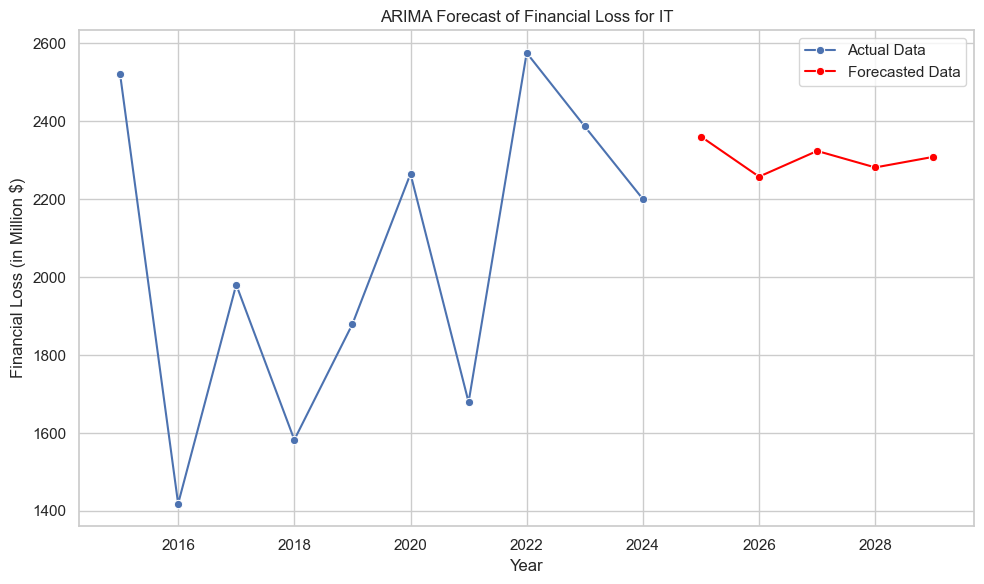

In [90]:
# Group data by Target Industry and calculate metrics
industry_metrics = cybersec_cleaned.groupby('Target Industry').agg({
    'Financial Loss (in Million $)': 'sum',
    'Number of Affected Users': 'sum',
    'Target Industry': 'count'  # This represents the number of incidents
}).rename(columns={'Target Industry': 'Number of Incidents'})

# Forecast Financial Loss for the top industry
top_industry = industry_metrics['Financial Loss (in Million $)'].idxmax()
financial_loss_ts = cybersec_cleaned[cybersec_cleaned['Target Industry'] == top_industry].groupby('Year')['Financial Loss (in Million $)'].sum()

# Fit ARIMA model
model = ARIMA(financial_loss_ts, order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=5)

# Prepare forecast data
forecast_years = pd.Series(range(financial_loss_ts.index[-1] + 1, financial_loss_ts.index[-1] + 6))
forecast_df = pd.DataFrame({'Year': forecast_years, 'Forecasted Loss': forecast.values})

# Combine original and forecasted data
combined_df = pd.concat([financial_loss_ts.reset_index(), forecast_df], ignore_index=True)

# Plot the combined data
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, x='Year', y='Financial Loss (in Million $)', label='Actual Data', marker='o')
sns.lineplot(data=forecast_df, x='Year', y='Forecasted Loss', label='Forecasted Data', marker='o', color='red')
plt.title(f'ARIMA Forecast of Financial Loss for {top_industry}')
plt.xlabel('Year')
plt.ylabel('Financial Loss (in Million $)')
plt.legend()
plt.tight_layout()
plt.show()